## Unit 1 Capstone: A/B Experiment

Over the course of my Thinkful curriculum, it is my goal to apply predictive analytics to my client's [Customer Relationship Management](https://en.wikipedia.org/wiki/Customer_relationship_management) (or "CRM") database.

It's my overall hypothesis that predective analytics will be a better predictor that HubSpot's standard "Likeliness to Close" rating.

This experiment, in accordance to Thinkful's Unit 1 Capstone, will explore my client's CRM database and run an A/B experiment on two variables from one of its datatables.

### Import Packages and Resize Charts

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [52]:
# Resize charts via seaborn
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

### Create function(s)

In [53]:
def WinsorizeCustom(data):
    quantiles = data.quantile([0.1, 0.9])
    q_05 = quantiles.loc[0.1]
    q_95 = quantiles.loc[0.9]

    out = np.where(data.values <= q_05,q_05, 
                                      np.where(data >= q_95, q_95, data)
                  )
    return out

### Import data

#### Deals

In [54]:
hs_deals = 'hs_deals-2018_08_14.csv'
df_deals_raw = pd.read_csv(hs_deals)

In [55]:
df_deals_raw.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Columns: 98 entries, Company ID to Parent Company
dtypes: float64(30), int64(1), object(67)
memory usage: 117.2+ KB


Deals, leads that have turned into accounts (customers), only have 153 entries, which is not enough data to run an experiment on. This data will prove useful later on when analyzing the attritubes of the accounts that can be applied to our lead datatables.

#### Companies (or Leads)

In [56]:
hs_companies = 'hs_companies-2018_09_29.csv'
df_companies_raw = pd.read_csv(hs_companies)

In [57]:
df_companies_raw.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Columns: 99 entries, Company ID to Parent Company
dtypes: float64(26), int64(1), object(72)
memory usage: 5.1+ MB


Companies, are leads before then become accounts. Initially, I thought this would be the only other dataset needed to be used for my predictive analytics capstone.

Unfortunately, after speaking with my client's VP of Marketing, this dataset is incomplete and needs to be combined with the last dataset, contacts. An indicator of incompleteness is the 'Lifecycle Stage', an automatically generated variable, only has 577 entries, which is less than 10% of the total records of the dataset.

#### Contacts

In [58]:
hs_contacts = 'hs_contacts-2018_09_29.csv'
df_contacts_raw = pd.read_csv(hs_contacts)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,15,18,29,32,37,44,47,63,67,69,70,71,76,93,112,118,147,157,164,187,188,195) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
df_contacts_raw.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11450 entries, 0 to 11449
Columns: 209 entries, Contact ID to Associated Company
dtypes: float64(69), int64(2), object(138)
memory usage: 18.3+ MB


Contacts are the individuals of the companies that our sales team builds relationships with during the sales process.

While it's more complete than the companies dataset, this data could use some cleaning, as it's much larger than the other datasets.

### Clean Contacts Dataset

In [60]:
#Limit df to rows with entries for Website URL
df_contacts = df_contacts_raw.dropna(axis='index', subset=['Company Name'])

In [61]:
#Limit df to columns with at least 150 entries
df_contacts = df_contacts.dropna(axis='columns',thresh=150)

In [62]:
# Use RegEx to drop columns w/ specific strings
df_contacts = df_contacts[df_contacts.columns.drop(list(df_contacts.filter(regex='IP ')))]
df_contacts = df_contacts[df_contacts.columns.drop(list(df_contacts.filter(regex='Phone')))]
df_contacts = df_contacts[df_contacts.columns.drop(list(df_contacts.filter(regex='Sticky')))]
df_contacts = df_contacts[df_contacts.columns.drop(list(df_contacts.filter(regex='Google')))]
df_contacts = df_contacts[df_contacts.columns.drop(list(df_contacts.filter(regex='Salesforce')))]

In [63]:
# Drop specific columns
df_contacts = df_contacts[df_contacts.columns.drop([
    'Notes', 'Street Address', 'Trade Show Name', 'City', 'Twitter Username'
])]

In [64]:
# Creates new, continuous variable columns for categorical variables
contact_dummy = pd.get_dummies(df_contacts['Lifecycle Stage'])


In [65]:
# View variables
df_contacts.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10417 entries, 0 to 11449
Columns: 110 entries, Contact ID to Associated Company
dtypes: float64(26), int64(2), object(82)
memory usage: 8.8+ MB


After reducing the number of columns and dropping some null values, the size of the dataset has been more than halved.

There is also enough data here to run an A/B test for my Unit 1 capstone.

### A/B Experiment

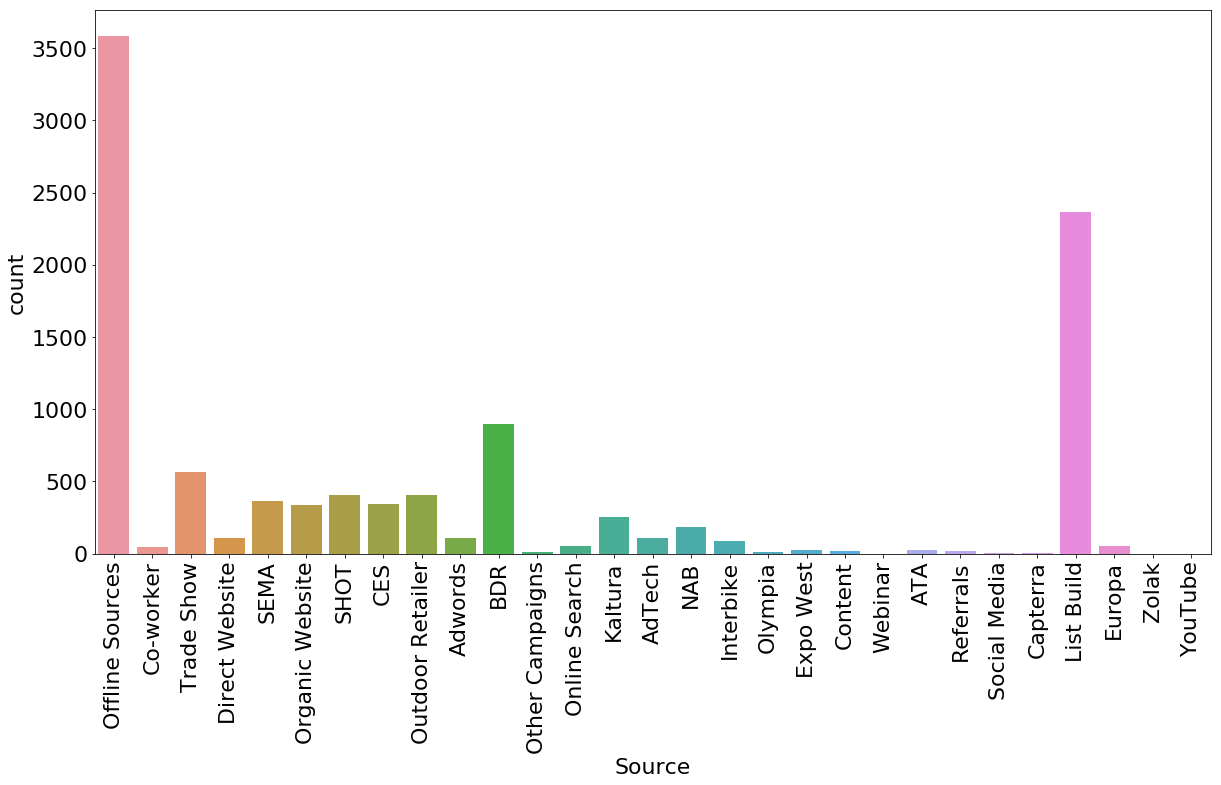

In [66]:
sns.countplot(x='Source', data=df_contacts)
plt.xticks(rotation=90);

The purpose of this experiment is to test when one source of leads is better than another, according to the "Likelihood to Close" metric. This metric, generated by HubSpot, is a rating that ranges from 0 - 100 probability that a lead will close within the next 90 days.

Our VP of Marketing suspects that this is in part driven by the source of the lead. An AB test of 'BDR' and 'List Build' should provide a reliable indicator on whether the source of a lead is driving the rating.

My **hypothesis** is that the *higher rate for BDR source* is not by chance, in comparison to the *List Build source rating*.

### The Experiment

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


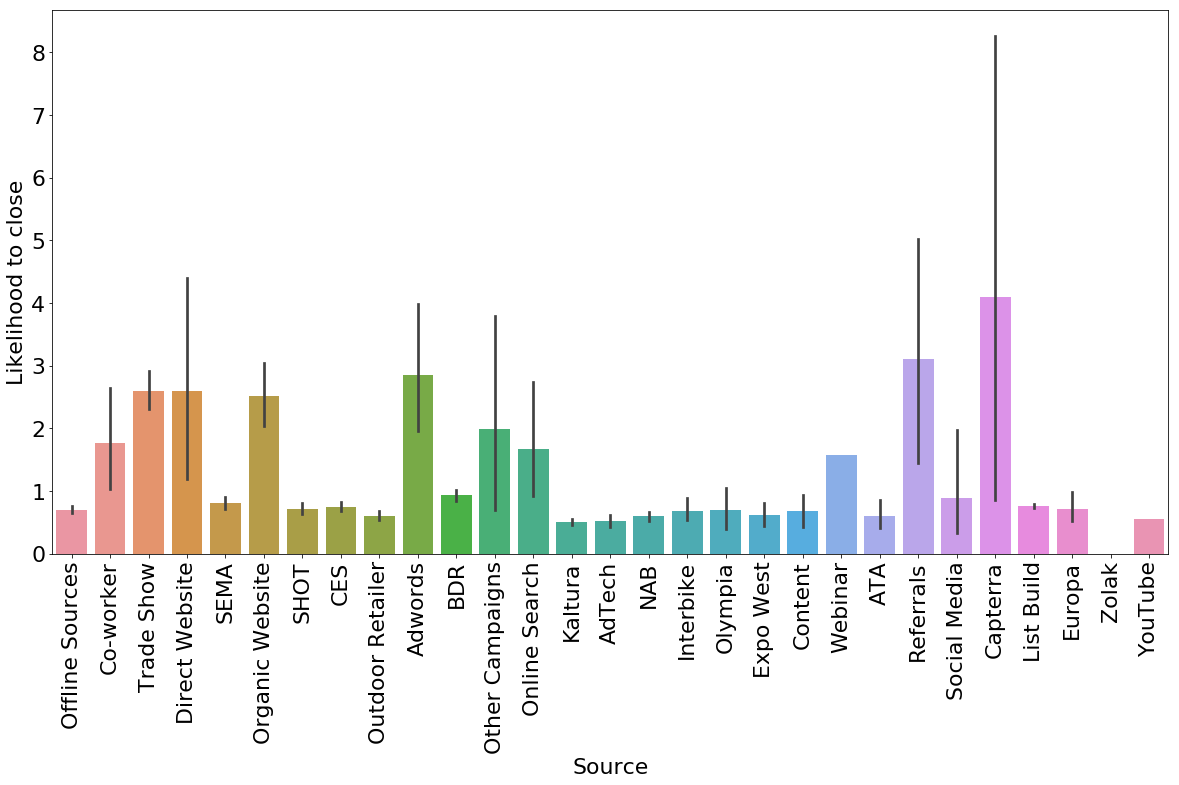

In [67]:
sns.barplot(x='Source', y='Likelihood to close', data=df_contacts)
plt.xticks(rotation=90);

In [76]:
# Create sample data.
bdr = df_contacts['Likelihood to close'][df_contacts.Source == 'BDR'].dropna()
list_build = df_contacts['Likelihood to close'][df_contacts.Source == 'List Build'].dropna()

# Use scipy.stats.ttest_ind.
t, p = stats.ttest_ind(bdr, list_build, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))


ttest_ind:            t = 3.67223  p = 0.000252382


As expected, my **hypothesis is correct**. A t value of nearly 4 indicates a massive difference between the two variables and an extremely low p value of 0.00025 makes it nearly statistically impossible that this an occurance of chance.

### Additional Analysis and Visualizations

In [35]:
# Create rating array and drop null values
rating = np.array(df_contacts['Likelihood to close'].dropna())

In [110]:
rating_winsor = WinsorizeCustom(df_contacts['Likelihood to close'].dropna())

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


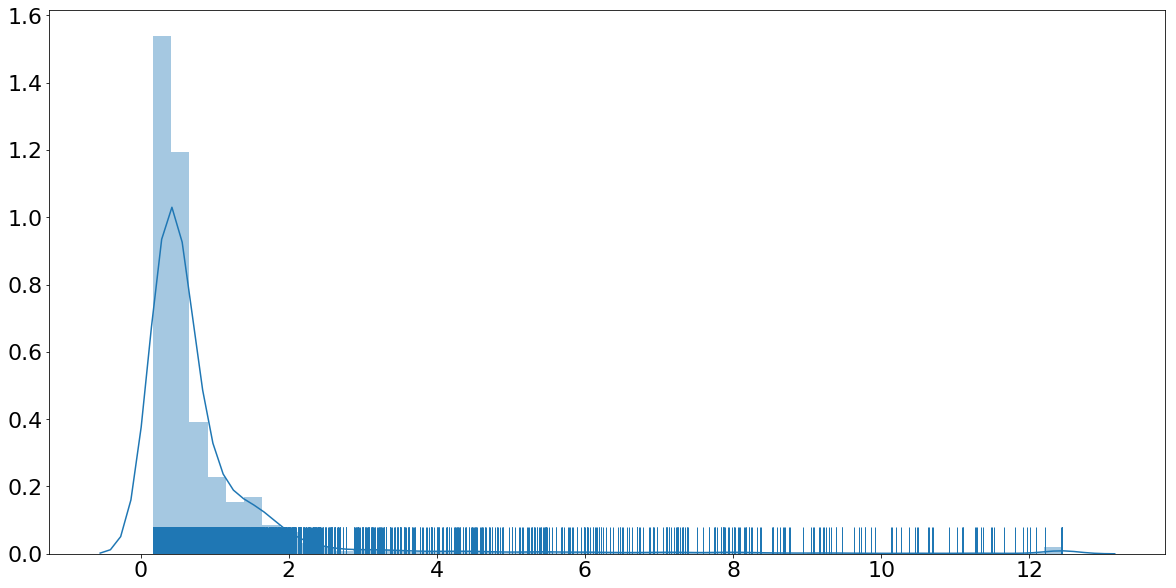

In [112]:
sns.distplot(rating_winsor, rug = True)

In [114]:
df_contacts.corr()

,Contact ID,Broadcast Clicks,Marketing emails opened,Total Revenue,Klout Score,Number of Pageviews,Facebook Clicks,Associated Deals,Recent Deal Amount,Number of times contacted,...,Event Revenue,Marketing emails clicked,Follower Count,Associated Company ID,Twitter Clicks,Likelihood to close,LinkedIn Connections,Sends Since Last Engagement,Days To Close,Marketing emails bounced
Contact ID,1.000000,0.016457,0.487042,-0.001467,-0.112696,-0.003371,-0.006218,-0.068090,0.005374,-0.067096,...,NaN,0.176609,-0.005691,0.840322,0.008267,0.230968,0.090362,0.467618,-0.790355,0.168144
Broadcast Clicks,0.016457,1.000000,-0.011709,-0.031569,NaN,0.020670,0.137854,-0.006832,-0.029081,0.027610,...,NaN,-0.015587,NaN,-0.012929,0.436359,0.110359,NaN,-0.013303,-0.020972,NaN
Marketing emails opened,0.487042,-0.011709,1.000000,-0.051766,0.159446,-0.009402,-0.011709,-0.013077,-0.050134,-0.045711,...,NaN,0.255613,-0.003166,0.456661,-0.011709,-0.007722,NaN,-0.115973,-0.003762,NaN
Total Revenue,-0.001467,-0.031569,-0.051766,1.000000,-0.653008,-0.049131,NaN,0.101335,0.977681,0.198592,...,NaN,NaN,-0.525631,0.013502,NaN,NaN,NaN,0.121102,0.137515,NaN
Klout Score,-0.112696,NaN,0.159446,-0.653008,1.000000,-0.074648,NaN,NaN,-0.653008,-0.050620,...,NaN,NaN,0.406152,-0.120367,NaN,-0.030475,-0.136346,0.018237,-0.030345,NaN
Number of Pageviews,-0.003371,0.020670,-0.009402,-0.049131,-0.074648,1.000000,0.252449,-0.017199,-0.043984,0.093263,...,NaN,0.173731,-0.011105,-0.003626,0.007854,0.141813,-0.003468,-0.029944,-0.035615,-0.012648
Facebook Clicks,-0.006218,0.137854,-0.011709,NaN,NaN,0.252449,1.000000,NaN,NaN,-0.008381,...,NaN,-0.015587,NaN,-0.008965,0.316146,0.022113,NaN,-0.013871,NaN,NaN
Associated Deals,-0.068090,-0.006832,-0.013077,0.101335,NaN,-0.017199,NaN,1.000000,-0.060225,0.195762,...,NaN,NaN,NaN,-0.050052,NaN,NaN,NaN,0.031814,0.035807,NaN
Recent Deal Amount,0.005374,-0.029081,-0.050134,0.977681,-0.653008,-0.043984,NaN,-0.060225,1.000000,0.180727,...,NaN,NaN,-0.525631,0.014111,NaN,NaN,NaN,0.104323,0.140889,NaN
Number of times contacted,-0.067096,0.027610,-0.045711,0.198592,-0.050620,0.093263,-0.008381,0.195762,0.180727,1.000000,...,NaN,0.039024,-0.014223,-0.042995,-0.008381,0.137749,0.016314,-0.034380,-0.126122,0.101079


In [115]:
df_contacts.describe()

,Contact ID,Broadcast Clicks,Marketing emails opened,Total Revenue,Klout Score,Number of Pageviews,Facebook Clicks,Associated Deals,Recent Deal Amount,Number of times contacted,...,Event Revenue,Marketing emails clicked,Follower Count,Associated Company ID,Twitter Clicks,Likelihood to close,LinkedIn Connections,Sends Since Last Engagement,Days To Close,Marketing emails bounced
count,1.041700e+04,10417.000000,1828.000000,170.000000,327.000000,10417.000000,10417.000000,467.000000,169.000000,5957.000000,...,10417.0,186.000000,554.000000,1.006600e+04,10417.000000,9582.000000,491.000000,7046.000000,772.000000,723.000000
mean,7.954949e+05,0.000672,1.336433,13704.405647,28.651376,2.197946,0.000768,1.027837,13209.461302,4.846903,...,0.0,1.043011,1477.438628,5.455738e+08,0.000192,0.947934,0.511202,1.168748,160.099741,1.056708
std,7.005237e+05,0.044896,0.672427,15040.447501,15.377286,62.136791,0.061965,0.188955,15059.105761,5.948294,...,0.0,0.203429,7572.510510,2.657699e+08,0.019596,1.906497,11.327471,1.003921,209.815914,0.254257
min,5.100000e+01,0.000000,1.000000,500.000000,10.000000,0.000000,0.000000,1.000000,500.000000,0.000000,...,0.0,1.000000,0.000000,1.963816e+08,0.000000,0.040000,0.000000,0.000000,1.000000,1.000000
25%,8.756500e+04,0.000000,1.000000,5175.000000,15.000000,0.000000,0.000000,1.000000,4800.000000,1.000000,...,0.0,1.000000,9.000000,2.703237e+08,0.000000,0.330000,0.000000,1.000000,1.000000,1.000000
50%,6.417510e+05,0.000000,1.000000,9000.000000,25.000000,0.000000,0.000000,1.000000,7800.000000,3.000000,...,0.0,1.000000,46.000000,5.077567e+08,0.000000,0.490000,0.000000,1.000000,37.500000,1.000000
75%,1.534560e+06,0.000000,1.000000,15468.750000,41.000000,0.000000,0.000000,1.000000,15000.000000,6.000000,...,0.0,1.000000,404.500000,8.323831e+08,0.000000,0.850000,0.000000,1.000000,312.000000,1.000000
max,1.983701e+06,4.000000,3.000000,100920.000000,87.000000,4669.000000,6.000000,3.000000,100920.000000,88.000000,...,0.0,2.000000,95273.000000,9.676485e+08,2.000000,55.970000,251.000000,14.000000,698.000000,3.000000
